In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random
import matplotlib
import scipy.optimize as opt
from scipy.optimize import minimize
from sklearn.metrics import classification_report,confusion_matrix#这个包是评价报告

# Multi-class classification

In [2]:
def load_data(path, transpose=True):
    data = loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

def plot_an_image(image):
#     """
#     image : (400,)
#     """
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))

def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

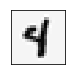

this should be 4


In [3]:
X, y = load_data('/Users/hsunku/Desktop/github/MachineLearning_AndrewNg/exercises/machine-learning-ex3/ex3/ex3data1.mat')
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))


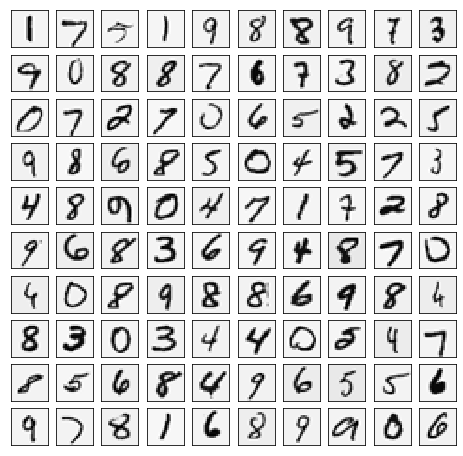

In [4]:
plot_100_image(X)

## Data Preparation

In [4]:
theta = np.zeros(401)
raw_X,raw_y = load_data('/Users/hsunku/Desktop/github/MachineLearning_AndrewNg/exercises/machine-learning-ex3/ex3/ex3data1.mat')
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)

y_matrix = []
for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))    # 见配图 "向量化标签.png"
# last one is k==10, it's digit 0, bring it to the first position，最后一列k=10，都是0，把最后一列放到第一列
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)

## sigmoid function

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## cost function
cost function: $J(\theta) = \frac{1}{m}\sum_{i=1}^m [-y^{(i)} log(h_{\theta}(x^{(i)})) - (1-y^{(i)}) log(1-h_{\theta}(x^{(i)}))]$

In [6]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

def regularized_cost(theta, X, y, l=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term

## Gradient descent

In [7]:
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

## train 1-d model

In [8]:
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.zeros(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    # get trained parameters
    final_theta = res.x

    return final_theta
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)


## train 10-d model

In [9]:
k_theta = np.array([logistic_regression(X,y[k],l=1) for k in range(10)])
k_theta

array([[-5.40510029e+00,  0.00000000e+00, -1.69065304e-09, ...,
        -2.31238561e-04,  4.91739787e-04,  0.00000000e+00],
       [-2.38113556e+00,  0.00000000e+00, -3.53887092e-11, ...,
         2.35014962e-04,  1.64666731e-05,  0.00000000e+00],
       [-3.18200918e+00,  0.00000000e+00, -1.60360527e-06, ...,
         2.12707122e-03, -1.48177185e-04,  0.00000000e+00],
       ...,
       [-1.90478883e+00,  0.00000000e+00, -7.92838112e-11, ...,
        -2.76937765e-02,  1.23780690e-03,  0.00000000e+00],
       [-7.98560981e+00,  0.00000000e+00, -7.06144801e-10, ...,
         8.79049589e-03, -6.39767570e-04,  0.00000000e+00],
       [-4.57188522e+00,  0.00000000e+00, -1.84367691e-08, ...,
        -9.95322242e-04, -1.21086228e-03,  0.00000000e+00]])

# prediction

In [10]:
prob_matrix=sigmoid(X@k_theta.T)
# np.set_printoptions(suppress=True)
y_pred = np.argmax(prob_matrix, axis=1)#返回沿轴axis最大值的索引，axis=1代表行
y_answer = raw_y.copy()
y_answer[y_answer==10] = 0
print(classification_report(y_answer, y_pred))
# for i in range(10):
#     pred=confusion_matrix((y_answer == i).astype(int),(y_pred == i).astype(int))
#     support = pred[1,1] + pred[1,0]
#     pp = pred[1,1] + pred[0,1]
#     precision = pred[1,1]/pp
#     recall = pred[1,1]/support
#     f1_score = 2*precision*recall/(precision+recall)
#     print(i,round(precision,2),round(recall,2),round(f1_score,2),support)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# **some facts regarding prediction**
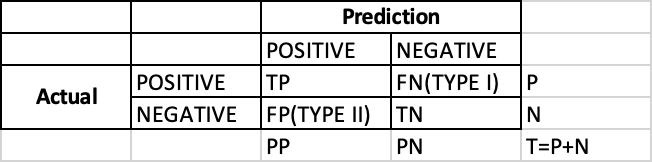
1. True Positive: predict postive when actual is postive
2. False Positive: predict positive when actual is negative
3. False Negative: predict negative when actual is positive
4. True Negative: predict negative when actual is negative
5. TYPE I ERROR: falsely reject null hypothesis which is correct, $\alpha$ is type I error
6. TYPE II ERROR: falsely accept null hypothesis which is incorrect, $\beta$ is type II error 
7. We cannot ensure that $\alpha$ and $\beta$ will be low at the same time.

precision = TP/(TP+FP); predict_positive(PP)= TP+FP; 真阳/预阳

recall(sensitivity) = TP/(TP+FN); positive = TP+FN; 真阳/实阳 

# Neural Networks
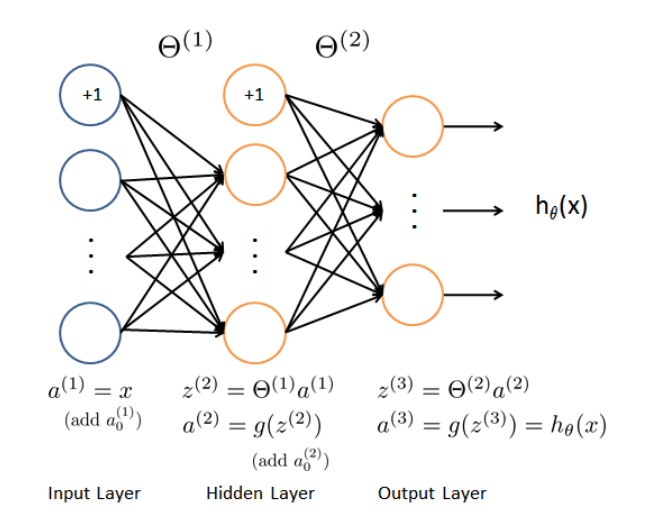

In [93]:
weights=loadmat('/Users/hsunku/Desktop/github/MachineLearning_AndrewNg/exercises/machine-learning-ex3/ex3/ex3weights.mat')
theta1,theta2=weights['Theta1'],weights['Theta2']
X, y = load_data('/Users/hsunku/Desktop/github/MachineLearning_AndrewNg/exercises/machine-learning-ex3/ex3/ex3data1.mat',transpose=False)
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  # intercept
theta1.shape,theta2.shape


((25, 401), (10, 26))

In [62]:
a1 = X
print(a1.shape)
z2 = a1@theta1.T
print(z2.shape)
z2 = np.insert(z2,0,values=np.ones(z2.shape[0]),axis=1)
a2 = sigmoid(z2)
z3 = a2@theta2.T
a3 = sigmoid(z3)
y_predict=np.argmax(a3,axis=1)+1
print(classification_report(y, y_predict))

(5000, 401)
(5000, 25)
              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [66]:
y[y != y_predict]

array([10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9], dtype=uint8)

In [82]:
X[y != y_predict]
def plot_all_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = 20

    # sample 100 image, reshape, reorg it
#     sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
#     sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=11, ncols=12, sharey=True, sharex=True, figsize=(9, 9))

    for r in range(11):
        for c in range(12):
            ax_array[r, c].matshow(X[12 * r + c].reshape((size, size)).T,
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  

IndexError: index 124 is out of bounds for axis 0 with size 124

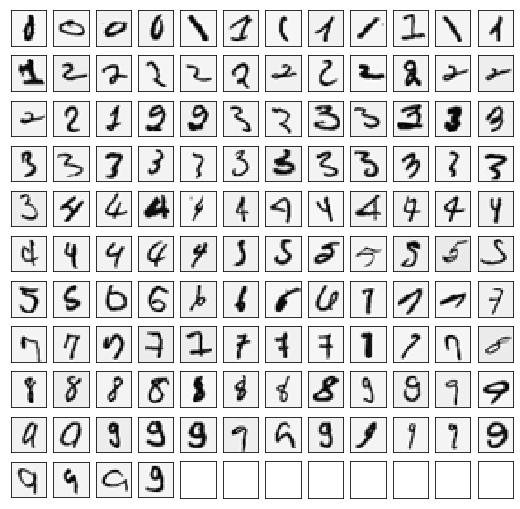

In [83]:
plot_all_image(X[:,1:][y != y_predict])

In [92]:
print('True value of false prediction')
print(y[y != y_predict])
print('predicted value of false prediction')
print(y_predict[y!=y_predict])


True value of false prediction
[10 10 10 10  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5
  5  5  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9]
predicted value of false prediction
[ 8  9  4  6  3  7  8  4  8  2  8  4  9  6  7  1  5  9  4 10  4  8  6  6
  4  8  1 10 10  5  7  2  6  2  8  9  5  5  7  1  7  5  6  5  5  9  1  7
  5  9  6  2  1  1  9  9  2  9  9  8  6  9  9  6  9  3  6  2  4  3  6  3
  3  6 10  5  1  1  5 10  1  4  4  4  4  9 10  2  2  9  1  9  1  3  9  4
  1  2  1  5  1  4  1  3  5 10  7  4  8 10  8  3  3  7  6  3  1  1  7  8
  7  4 10  3]
